# Structural Analysis of the Interface

1. Import Statements
2. Data Preparation
3. Structural Feature Analysis (Surface Area, H-Bonds, Salt-Bridges, Binding Score)
4. Sequence Analysis 

## Import Statements

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns 
import matplotlib.pyplot as plt
import random
import os
from pymol import cmd
from collections import defaultdict, Counter 
from sklearn.preprocessing import MinMaxScaler
from Bio.SeqUtils import seq1
from Bio import SeqIO 
from Bio import pairwise2
from scipy.cluster.hierarchy import linkage, fcluster, dendrogram

import matplotlib.cm as cm
from scipy.stats import kruskal
from itertools import combinations
from scipy.stats import mannwhitneyu



plt.rcParams['font.family'] = 'Calibri'
plt.rcParams['axes.titleweight'] = 'bold'


/opt/anaconda3/envs/pymol-env/lib/python3.9/site-packages/Bio/pairwise2.py:278: BiopythonDeprecationWarning: Bio.pairwise2 has been deprecated, and we intend to remove it in a future release of Biopython. As an alternative, please consider using Bio.Align.PairwiseAligner as a replacement, and contact the Biopython developers if you still need the Bio.pairwise2 module.
  warnings.warn(


## Data Preparation

### Read given Checkpoint PDB ID information

In [2]:
# Define datasets for individual inhibitory checkpoints
data = pd.read_csv('data/ab_ag.tsv', sep='\t')
pd1 = data[data['compound'].str.contains('PD-1', na=False)]
pdl1 = data[data['compound'].str.contains('PD-L1', na=False)]
ctla4 = data[data['compound'].str.contains('CTLA-4', na=False)]
kir = data[data['compound'].str.contains('KIR', na=False)]
lag3 = data[data['compound'].str.contains('LAG', na=False)]
tim3 = data[data['compound'].str.contains('TIM3', na=False)]

In [3]:
# Filter out necessary columns
pd1 = pd1[['pdb', 'Hchain', 'Lchain', 'antigen_chain', 'antigen_type', 'antigen_name', 'compound', 'resolution', 'method']]
pdl1 = pdl1[['pdb', 'Hchain', 'Lchain', 'antigen_chain', 'antigen_type', 'antigen_name', 'compound', 'resolution', 'method']]
ctla4 = ctla4[['pdb', 'Hchain', 'Lchain', 'antigen_chain', 'antigen_type', 'antigen_name', 'compound', 'resolution', 'method']]
kir = kir[['pdb', 'Hchain', 'Lchain', 'antigen_chain', 'antigen_type', 'antigen_name', 'compound', 'resolution', 'method']]
lag3 = lag3[['pdb', 'Hchain', 'Lchain', 'antigen_chain', 'antigen_type', 'antigen_name', 'compound', 'resolution', 'method']]
tim3 = tim3[['pdb', 'Hchain', 'Lchain', 'antigen_chain', 'antigen_type', 'antigen_name', 'compound', 'resolution', 'method']]

In [4]:
combined_dataset = [pdl1, pd1, ctla4, kir, lag3, tim3]

# Shuffle the list randomly
random.shuffle(combined_dataset)

# Concatenate them in the new random order
merged_df = pd.concat(combined_dataset, ignore_index=True)
shuffled_df = merged_df.sample(frac=1).reset_index(drop=True)

In [5]:
shuffled_df = shuffled_df[shuffled_df['resolution'] < 3.5]
shuffled_df = shuffled_df.dropna()

### Extract and Clean Antibody-Checkpoint Associations

In [ ]:
# Filter all relevant rows: those with 'mab' OR 'M6903'
ab_mask = shuffled_df['compound'].str.contains('mab|M6903', na=False, case=False)
shuffled_df_ab = shuffled_df[ab_mask]

# Extract antibody names
shuffled_df_ab['antibody'] = shuffled_df_ab['compound'].str.extract(r'\b(\w*mab)\b', expand=False)

# Fill in M6903 manually where missing
m6903_mask = shuffled_df_ab['compound'].str.contains('M6903', na=False)
shuffled_df_ab.loc[m6903_mask, 'antibody'] = shuffled_df_ab.loc[m6903_mask, 'antibody'].fillna('M6903')

# Extract checkpoint names
checkpoints_pattern = r'\b(PD-1|PD-L1|CTLA-4|KIR2DL3|TIM3)\b'
shuffled_df_ab['checkpoint'] = shuffled_df_ab['compound'].str.extract(checkpoints_pattern, expand=False)

# Final formatting
shuffled_df_ab = shuffled_df_ab[['antibody', 'checkpoint', 'pdb', 'Hchain', 'Lchain', 'antigen_chain']]
shuffled_df_ab['antibody'] = shuffled_df_ab['antibody'].str.upper()

shuffled_df_ab

/var/folders/4b/v_2x0lss5_bfxdnbx8y02n6r0000gn/T/ipykernel_27384/3038541163.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  shuffled_df_ab['antibody'] = shuffled_df_ab['compound'].str.extract(r'\b(\w*mab)\b', expand=False)
/var/folders/4b/v_2x0lss5_bfxdnbx8y02n6r0000gn/T/ipykernel_27384/3038541163.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  shuffled_df_ab['checkpoint'] = shuffled_df_ab['compound'].str.extract(checkpoints_pattern, expand=False)


,antibody,checkpoint,pdb,Hchain,Lchain,antigen_chain
0,CEMIPLIMAB,PD-1,8gy5,H,L,P
1,M6903,TIM3,6txz,H,L,A
3,AVELUMAB,PD-L1,5grj,H,L,A
4,CEMIPLIMAB,PD-1,8gy5,A,B,Q
5,IPILIMUMAB,CTLA-4,7su1,H,L,C
6,IPILIMUMAB,CTLA-4,9dq4,H,L,A
7,CAMRELIZUMAB,PD-1,7cu5,A,A,Q
9,ATEZOLIZUMAB,PD-L1,5x8l,H,M,C
10,TISLELIZUMAB,PD-1,7cgw,H,L,P
12,ATEZOLIZUMAB,PD-L1,5x8l,S,N,D


In [7]:
pdb_list = shuffled_df_ab['pdb'].unique().tolist()

In [8]:
# make a list of the columns 
shuffled_df_ab = shuffled_df_ab[['pdb', 'Hchain', 'Lchain', 'antigen_chain']]
extracted_list = shuffled_df_ab.values.tolist()

extracted_list


[['8gy5', 'H', 'L', 'P'],
 ['6txz', 'H', 'L', 'A'],
 ['5grj', 'H', 'L', 'A'],
 ['8gy5', 'A', 'B', 'Q'],
 ['7su1', 'H', 'L', 'C'],
 ['9dq4', 'H', 'L', 'A'],
 ['7cu5', 'A', 'A', 'Q'],
 ['5x8l', 'H', 'M', 'C'],
 ['7cgw', 'H', 'L', 'P'],
 ['5x8l', 'S', 'N', 'D'],
 ['5ggr', 'A', 'B', 'Y'],
 ['5xj4', 'H', 'L', 'A'],
 ['5x8m', 'B', 'C', 'A'],
 ['5jxe', 'D', 'C', 'B'],
 ['6xkr', 'H', 'L', 'P'],
 ['7wvm', 'A', 'B', 'E'],
 ['5ggv', 'H', 'L', 'Y'],
 ['5wt9', 'H', 'L', 'G'],
 ['5ggr', 'H', 'L', 'Z'],
 ['5tru', 'H', 'L', 'C'],
 ['7su0', 'I', 'M', 'D'],
 ['7su0', 'H', 'L', 'C'],
 ['7cu5', 'B', 'B', 'E'],
 ['6txz', 'I', 'M', 'B'],
 ['5ggs', 'C', 'D', 'Y'],
 ['5b8c', 'B', 'A', 'C'],
 ['5ggs', 'A', 'B', 'Z'],
 ['6txz', 'J', 'N', 'C'],
 ['5xj3', 'A', 'B', 'C'],
 ['7bxa', 'H', 'L', 'P'],
 ['5tru', 'h', 'l', 'c'],
 ['5x8l', 'J', 'O', 'E'],
 ['5b8c', 'E', 'D', 'F'],
 ['5xj3', 'D', 'E', 'F'],
 ['5jxe', 'G', 'F', 'A'],
 ['5xxy', 'H', 'L', 'A'],
 ['7wsl', 'H', 'L', 'D'],
 ['6rp8', 'h', 'l', 'c'],
 ['6rp8', 'H

## Structural Feature Analysis 

### Surface Area, Hydrogen-Bonds and Saltbridges Extraction

In [12]:
section = 'paratope' # choose paratope or epitope
root_folder = "structures"
cutoff_distance = 5.0
hbond_cutoff = 3.5
salt_cutoff = 4.0
bsa_threshold = 0.1

results = []

# Define interacting partners based on section
def get_partner_chains(h_chain, l_chain, ag_chain, section):
    if section == 'paratope':
        source_chain = f"{h_chain}+{l_chain}"
        target_chain = ag_chain
    elif section == 'epitope':
        source_chain = ag_chain
        target_chain = f"{h_chain}+{l_chain}"
    return source_chain, target_chain


for pdb_id, h_chain, l_chain, ag_chain in extracted_list:
    pdb_path = None
    for dirpath, _, filenames in os.walk(root_folder):
        for file in filenames:
            if file.lower() == f"{pdb_id.lower()}.pdb":
                pdb_path = os.path.join(dirpath, file)
                break
        if pdb_path:
            break

    if not pdb_path:
        print(f"Skipping {pdb_id}: PDB file not found")
        continue

    print(f"\n Processing {pdb_id} ({section})...")
    cmd.reinitialize()
    cmd.bg_color("white")
    cmd.load(pdb_path)

    source_chain, target_chain = get_partner_chains(h_chain, l_chain, ag_chain, section)

    # Define antigen selection for coloring
    if section == "epitope":
        cmd.select("antigen", f"chain {ag_chain}")
    else:
        cmd.select("antibody", f"chain {source_chain}")
        
    # Define selections
    cmd.select("source", f"chain {source_chain}")
    cmd.select("target", f"chain {target_chain}")
    cmd.select(section, f"source within {cutoff_distance} of target")

    # Color antibody chains 
    cmd.color("cesium", f"chain {h_chain}")
    cmd.color("cesium", f"chain {l_chain}")

    # Color antigen chain 
    cmd.color("teal", f"chain {ag_chain}")

    # Highlight paratope/epitope
    cmd.color("yellow", f"{section}")

    buried_residues = []
    if cmd.count_atoms(section) == 0:
        print(" No atoms found, skipping BSA")
        num_hbonds_filtered = 0
    else:
        residue_set = set()
        model = cmd.get_model(section)
        for atom in model.atom:
            residue_set.add((atom.chain, atom.resi))

        for chain, resi in residue_set:
            resid_sel = f"(chain {chain} and resi {resi})"
            try:
                # Create source-only object (no target)
                cmd.create("source_only", f"chain {source_chain}")
                cmd.select("res_in_source_only", f"source_only and chain {chain} and resi {resi}")
                cmd.get_area("res_in_source_only", load_b=1)
                sasa_free = sum([a.b for a in cmd.get_model("res_in_source_only").atom])
                cmd.delete("source_only")
                cmd.delete("res_in_source_only")

                # SASA in complex
                cmd.get_area(resid_sel, load_b=1)
                sasa_complex = sum([a.b for a in cmd.get_model(resid_sel).atom])
                bsa = sasa_free - sasa_complex

                print(f"   Residue {chain}:{resi} — BSA={bsa:.2f}")
                if bsa > bsa_threshold:
                    buried_residues.append((chain, resi))

            except Exception as e:
                print(f" Error {chain}:{resi} → {e}")
                continue

        if buried_residues:
            buried_sel = " or ".join([f"(chain {c} and resi {r})" for c, r in buried_residues])
            cmd.select(f"buried_{section}", buried_sel)

    

            # Filtered H-bonds
            hbonds_filtered = cmd.find_pairs(f"buried_{section}", "target", mode=1, cutoff=hbond_cutoff)
            num_hbonds_filtered = len(hbonds_filtered)
            print(f" Filtered H-bonds: {num_hbonds_filtered}")
        else:
            print(" No buried residues found.")
            num_hbonds_filtered = 0

    # SASA area of selections
    try:
        buried_area = cmd.get_area(f"buried_{section}")
    except:
        buried_area = 0.0
    try:
        total_area = cmd.get_area(section)
    except:
        total_area = 0.0

    print(f" {section.capitalize()} SASA: {total_area:.2f} Å²")

    # Salt bridges from buried residues only
    if buried_residues:
        cmd.select("acidic_buried", f"buried_{section} and resn ASP+GLU and name OD1+OD2+OE1+OE2")
        cmd.select("basic_target", f"target and resn LYS+ARG+HIS and name NZ+NH1+NH2+ND1+NE2")
        sb1 = cmd.find_pairs("acidic_buried", "basic_target", cutoff=salt_cutoff, mode=1)

        cmd.select("acidic_target", f"target and resn ASP+GLU and name OD1+OD2+OE1+OE2")
        cmd.select("basic_buried", f"buried_{section} and resn LYS+ARG+HIS and name NZ+NH1+NH2+ND1+NE2")
        sb2 = cmd.find_pairs("acidic_target", "basic_buried", cutoff=salt_cutoff, mode=1)

        for sel in ("acidic_buried", "basic_target", "acidic_target", "basic_buried"):
            cmd.delete(sel)

        num_salt_bridges = len(sb1) + len(sb2)
        print(f" Salt bridges (buried): {num_salt_bridges}")
    else:
        num_salt_bridges = 0
        print(f" Salt bridges skipped")

    # Save session
    session_out = os.path.join(dirpath, f"{pdb_id}_{section}.pse")
    cmd.save(session_out)

    # Save result
    results.append({
        "pdb_id": pdb_id,
        "H_chain": h_chain,
        "L_chain": l_chain,
        "antigen_chain": ag_chain,
        f"buried_{section}_area": buried_area,
        "num_filtered_hbonds": num_hbonds_filtered,
        "num_salt_bridges": num_salt_bridges,
        "folder": os.path.basename(dirpath)
    })

# Export results
output_dir = f"data/structural_analysis/{section.capitalize()}"
os.makedirs(output_dir, exist_ok=True)
output_file = os.path.join(output_dir, f"{section}_hbonds_salt_bridges_summary.csv")
df = pd.DataFrame(results)
df.to_csv(output_file, index=False)
print(f"\n Results saved to '{output_file}'")



 Processing 8gy5 (paratope)...
   Residue H:59 — BSA=0.86
   Residue H:57 — BSA=3.73
   Residue H:99 — BSA=0.00
   Residue L:30 — BSA=0.00
   Residue L:32 — BSA=0.00
   Residue H:55 — BSA=0.00
   Residue H:52 — BSA=3.02
   Residue L:421 — BSA=0.00
   Residue H:102 — BSA=0.00
   Residue H:376 — BSA=0.00
   Residue L:318 — BSA=0.00
   Residue H:100 — BSA=1.47
   Residue H:382 — BSA=0.00
   Residue H:56 — BSA=3.37
   Residue H:26 — BSA=0.00
   Residue L:93 — BSA=0.00
   Residue H:344 — BSA=0.00
   Residue L:92 — BSA=0.86
   Residue H:355 — BSA=0.00
   Residue H:31 — BSA=0.00
   Residue H:101 — BSA=0.00
   Residue H:32 — BSA=0.00
   Residue H:401 — BSA=0.00
   Residue H:310 — BSA=0.00
   Residue L:91 — BSA=0.00
   Residue H:335 — BSA=0.00
   Residue H:28 — BSA=0.00
   Residue H:54 — BSA=0.00
   Residue H:338 — BSA=0.00
   Residue H:1 — BSA=0.00
   Residue L:96 — BSA=0.00
   Residue H:27 — BSA=0.00
   Residue H:53 — BSA=0.00
   Residue L:94 — BSA=0.71
   Residue L:412 — BSA=0.00
 Filtered 

In [56]:
df_struc_info = pd.read_csv(f"data/structural_analysis/{section.capitalize()}/{section}_hbonds_salt_bridges_summary.csv")
print(df_struc_info['pdb_id'].value_counts())
print(len(df_struc_info))

pdb_id
5x8l    5
5b8c    4
6txz    4
5xj3    4
7cu5    2
5jxe    2
7cgw    2
5ggs    2
6rp8    2
7wvm    2
8gy5    2
5ggr    2
7bxa    2
7su0    2
5tru    2
6k0y    1
6xkr    1
5xxy    1
5x8m    1
7wsl    1
5grj    1
7su1    1
9dq4    1
5xj4    1
9dq3    1
5wt9    1
5ggv    1
8tui    1
Name: count, dtype: int64
52


### Visualizing Structural Features

#### barplot - surface area 

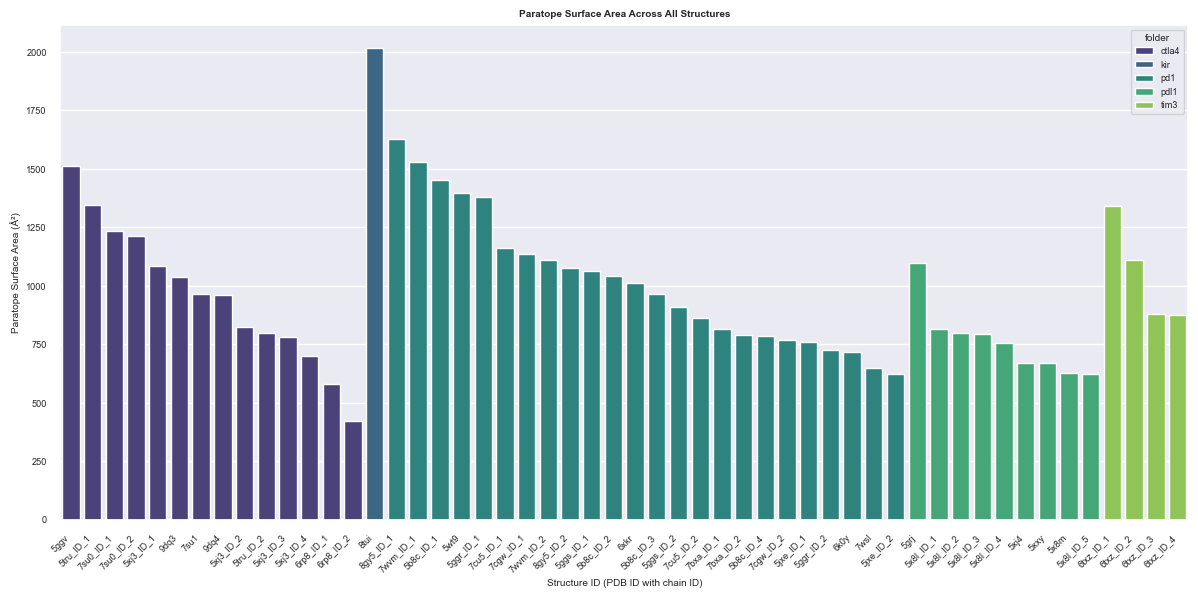

In [58]:
area = f"buried_{section}_area"
df_sorted = df_struc_info.sort_values(by=["folder", area], ascending=[True, False]).copy()

# Count how many times each pdb_id appears
id_frequencies = Counter(df_sorted["pdb_id"])
id_tracker = defaultdict(int)

# Build structure_id column
structure_ids = []

for pdb_id in df_sorted["pdb_id"]:
    if id_frequencies[pdb_id] == 1:
        structure_ids.append(pdb_id)
    else:
        id_tracker[pdb_id] += 1
        structure_ids.append(f"{pdb_id}_ID_{id_tracker[pdb_id]}")

df_sorted["structure_id"] = structure_ids

# Plotting 
plt.figure(figsize=(12, 6))
sns.barplot(data=df_sorted, x="structure_id", y=f"buried_{section}_area", hue="folder", dodge=False, palette="viridis")

plt.title(f"{section.capitalize()} Surface Area Across All Structures")
plt.xlabel("Structure ID (PDB ID with chain ID)")
plt.ylabel(f"{section.capitalize()} Surface Area (Å²)")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.savefig(f'plots/structural_analysis/{section.capitalize()}/{section}_surface_area_across_all_structures.pdf', bbox_inches='tight')
plt.show()



In [59]:
df_sorted.to_csv(f"data/structural_analysis/{section.capitalize()}/{section}_hbonds_salt_bridges_summary.csv", index=False)

#### Scatter Plot - Hydrogen Bonds vs Surface Area

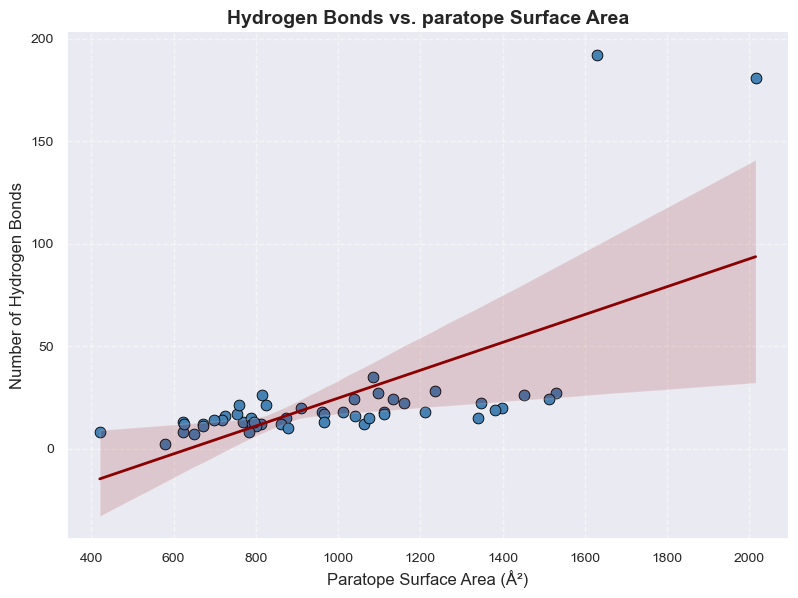

In [60]:
plt.figure(figsize=(8, 6))

# Scatterplot
sns.scatterplot(
    data=df_struc_info,
    x=f"buried_{section}_area",
    y="num_filtered_hbonds",
    s=60,
    color="steelblue",
    edgecolor="black"
)

# Regression line
sns.regplot(
    data=df_struc_info,
    x=f"buried_{section}_area",
    y="num_filtered_hbonds",
    scatter=False,
    color="darkred",
    line_kws={'linewidth': 2}
)

# Styling
plt.title(f"Hydrogen Bonds vs. {section} Surface Area", fontsize=14, fontweight="bold")
plt.xlabel(f"{section.capitalize()} Surface Area (Å²)", fontsize=12)
plt.ylabel("Number of Hydrogen Bonds", fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.grid(axis='both', linestyle='--', alpha=0.5)
sns.despine()
plt.tight_layout()

# Save (optional)
plt.savefig(f"plots/structural_analysis/{section.capitalize()}/hbonds_vs_surface_area_{section}.pdf", bbox_inches='tight')
plt.show()


#### Barplot - Hydrogen Bonds per PDB ID

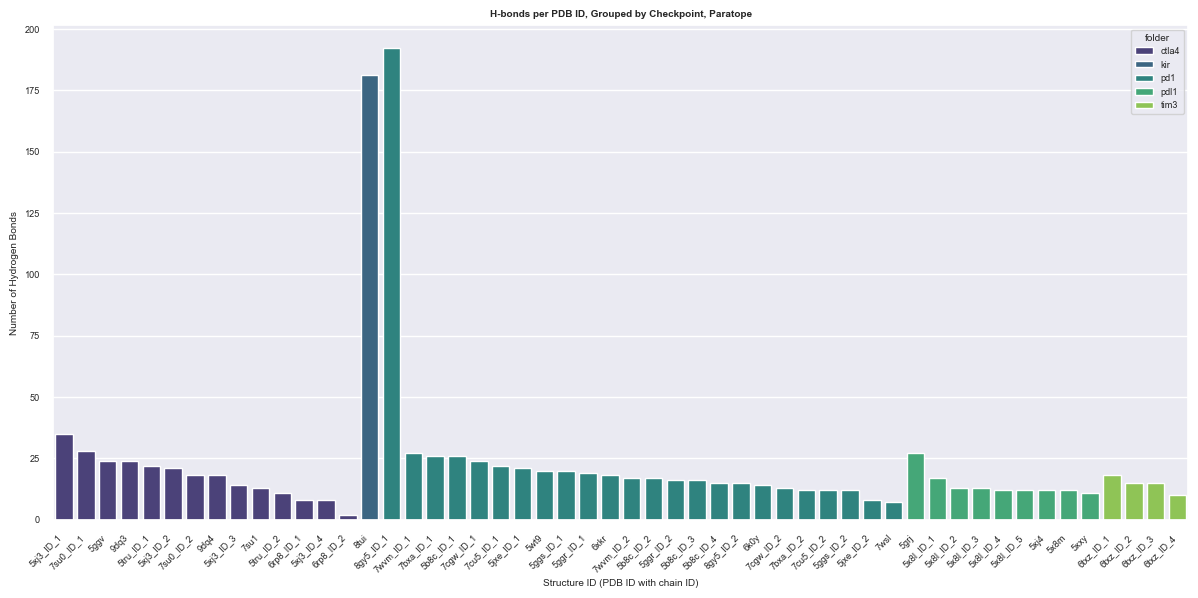

In [61]:
df_sorted_h = df_struc_info.sort_values(by=["folder", "num_filtered_hbonds"], ascending=[True, False]).copy()

# Count how many times each pdb_id appears
id_frequencies = Counter(df_sorted_h["pdb_id"])
id_tracker = defaultdict(int)

# Build structure_id column
structure_ids = []

for pdb_id in df_sorted_h["pdb_id"]:
    if id_frequencies[pdb_id] == 1:
        structure_ids.append(pdb_id)
    else:
        id_tracker[pdb_id] += 1
        structure_ids.append(f"{pdb_id}_ID_{id_tracker[pdb_id]}")

df_sorted_h["structure_id"] = structure_ids

# Plotting
plt.figure(figsize=(12, 6))
sns.barplot(data=df_sorted_h, x="structure_id", y="num_filtered_hbonds", hue="folder", dodge=False, palette="viridis")

plt.title(f"H-bonds per PDB ID, Grouped by Checkpoint, {section.capitalize()}")
plt.xlabel("Structure ID (PDB ID with chain ID)")
plt.ylabel("Number of Hydrogen Bonds")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.savefig(f'plots/structural_analysis/{section.capitalize()}/{section}_h_bonds_per_PDB.pdf', bbox_inches='tight')
plt.show()

#### Barplot - Salt Bridges per PDB ID

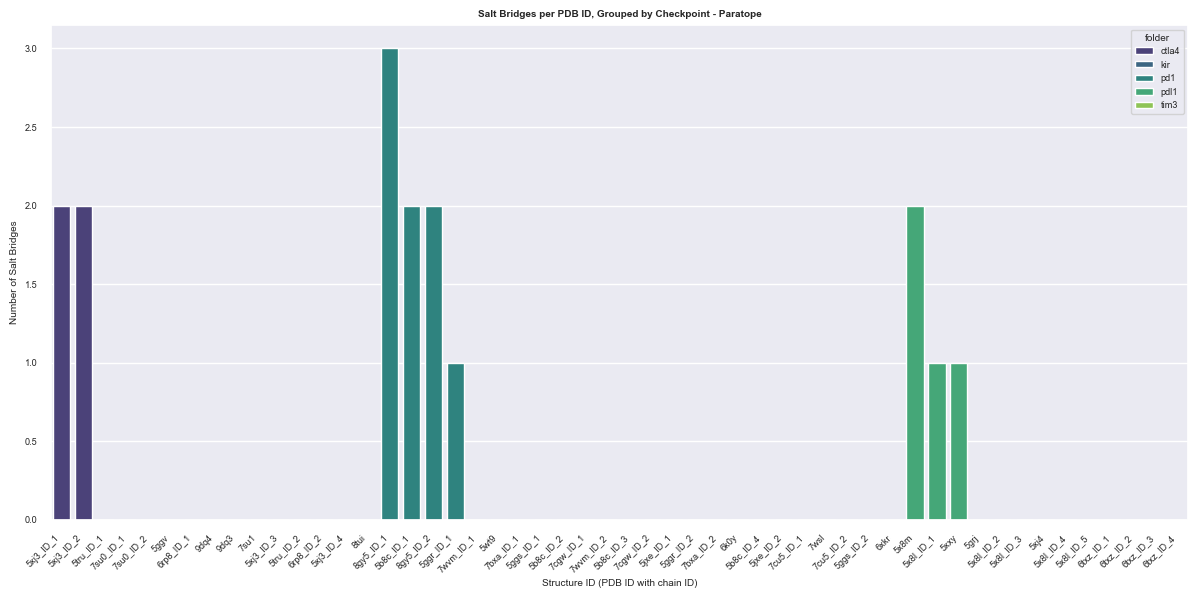

In [62]:

df_sorted_s = df_struc_info.sort_values(by=["folder", "num_salt_bridges"], ascending=[True, False]).copy()

# Count how many times each pdb_id appears
id_frequencies = Counter(df_sorted_s["pdb_id"])
id_tracker = defaultdict(int)

# Build structure_id column
structure_ids = []

for pdb_id in df_sorted_s["pdb_id"]:
    if id_frequencies[pdb_id] == 1:
        structure_ids.append(pdb_id)
    else:
        id_tracker[pdb_id] += 1
        structure_ids.append(f"{pdb_id}_ID_{id_tracker[pdb_id]}")

df_sorted_s["structure_id"] = structure_ids


# Plotting 
plt.figure(figsize=(12, 6))
sns.barplot(data=df_sorted_s, x="structure_id", y="num_salt_bridges", hue="folder", dodge=False, palette="viridis")

plt.title(f"Salt Bridges per PDB ID, Grouped by Checkpoint - {section.capitalize()}")
plt.xlabel("Structure ID (PDB ID with chain ID)")
plt.ylabel("Number of Salt Bridges")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.savefig(f'plots/structural_analysis/{section.capitalize()}/{section}_salt_bridges_per_PDB.pdf', bbox_inches='tight')
plt.show() 



## Binding Score 

In [68]:
#normalizing with MinMax
scaler = MinMaxScaler()
df = pd.read_csv(f"data/structural_analysis/{section.capitalize()}/{section}_hbonds_salt_bridges_summary.csv")

features = df[["num_filtered_hbonds", "num_salt_bridges", f"buried_{section}_area"]].copy()
normalized = scaler.fit_transform(features)

df_norm = pd.DataFrame(normalized, columns=features.columns)
df_norm["pdb_id"] = df["pdb_id"]  
df_norm["structure_id"] = df["structure_id"]  

# Create a binding strength score
weights = {
    "num_filtered_hbonds": 0.4,
    "num_salt_bridges": 0.4,
    f"buried_{section}_area": 0.2
}

df_norm["binding_score"] = (
    df_norm["num_filtered_hbonds"] * weights["num_filtered_hbonds"] +
    df_norm["num_salt_bridges"] * weights["num_salt_bridges"] +
    df_norm[f"buried_{section}_area"] * weights[f"buried_{section}_area"]
)

df_norm.to_csv(f"data/structural_analysis/{section.capitalize()}/{section}_hbonds_salt_bridges_summary.csv", index=False)

In [77]:
# Sort the dataframe
df_sorted_bs = df_norm.sort_values(
    by=["binding_score", "num_filtered_hbonds", "num_salt_bridges", f"buried_{section}_area"],
    ascending=[False, False, False, False]  
).copy()
# Count appearances
id_frequencies = Counter(df_sorted_bs["pdb_id"])
id_tracker = defaultdict(int)


df_sorted_bs.to_csv(f"data/structural_analysis/{section.capitalize()}/{section}_hbonds_salt_bridges_summary.csv", index=False)

### Barplot - Binding Score Composition per PDB ID

/var/folders/4b/v_2x0lss5_bfxdnbx8y02n6r0000gn/T/ipykernel_27384/2423592292.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  viridis = cm.get_cmap("viridis")


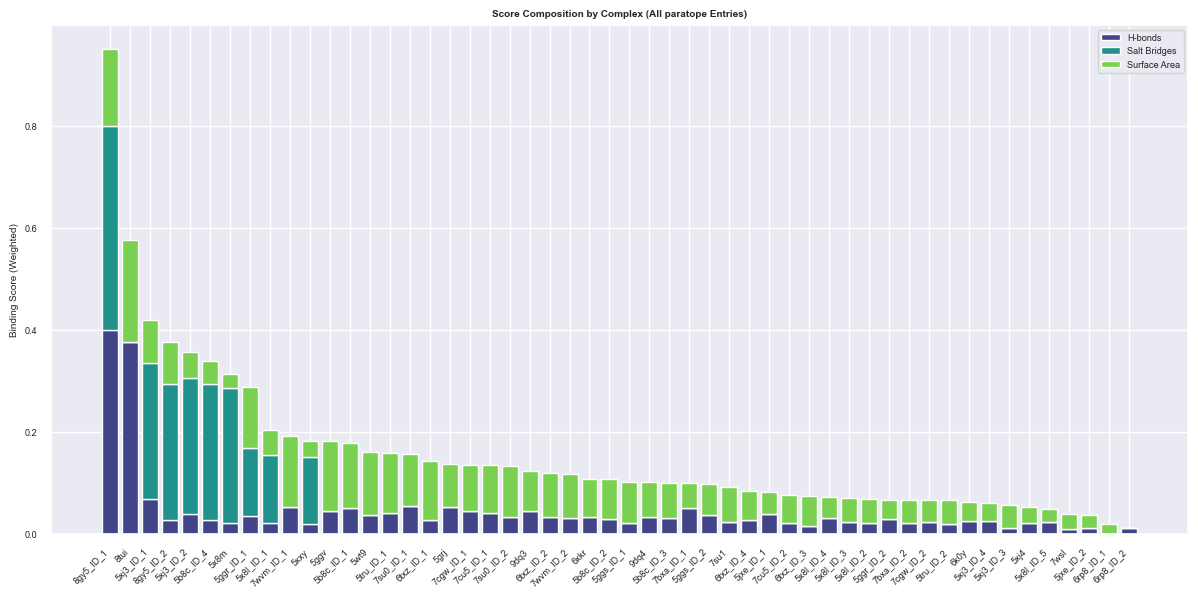

In [70]:
# Sort by binding score again
top = df_sorted_bs.sort_values("binding_score", ascending=False)

# Use viridis colormap
viridis = cm.get_cmap("viridis")
colors = viridis(np.linspace(0.2, 0.8, 3))

plt.figure(figsize=(12, 6))

# Plot H-bonds
plt.bar(
    top["structure_id"],
    top["num_filtered_hbonds"] * 0.4,
    label="H-bonds",
    color=colors[0],
    bottom=0
)

# Plot Salt Bridges
plt.bar(
    top["structure_id"],
    top["num_salt_bridges"] * 0.4,
    label="Salt Bridges",
    color=colors[1],
    bottom=top["num_filtered_hbonds"] * 0.4
)

# Plot Surface Area
plt.bar(
    top["structure_id"],
    top[f"buried_{section}_area"] * 0.2,
    label="Surface Area",
    color=colors[2],
    bottom=(top["num_filtered_hbonds"] + top["num_salt_bridges"]) * 0.4
)

plt.xticks(rotation=45, ha="right")
plt.ylabel("Binding Score (Weighted)")
plt.title(f"Score Composition by Complex (All {section} Entries)")
plt.legend()
plt.tight_layout()
plt.savefig(f"plots/structural_analysis/{section.capitalize()}/{section}_binding_affinity_score.pdf", bbox_inches="tight")
plt.show()




## Sequence Analysis

### Sequences Extraction

In [72]:
root_folder = "structures"
cutoff_distance = 5.0 
section = 'paratope' # choose 'paratope' or 'epitope'
bsa_threshold = 0.1  
results = []

# Ensure extracted_list is defined
if 'extracted_list' not in locals():
    extracted_list = []  

# Loop through all extracted entries
for pdb_id, h_chain, l_chain, ag_chain in extracted_list:
    pdb_path = None
    for dirpath, _, filenames in os.walk(root_folder):
        for file in filenames:
            if file.lower() == f"{pdb_id.lower()}.pdb":
                pdb_path = os.path.join(dirpath, file)
                break
        if pdb_path:
            break

    if not pdb_path:
        print(f"Skipping {pdb_id}: PDB file not found")
        continue
    else:
        print(f"Processing {pdb_id}...")

    cmd.reinitialize()
    cmd.load(pdb_path)

    # Define selections
    cmd.select("antibody", f"chain {h_chain}+{l_chain}")
    cmd.select("antigen", f"chain {ag_chain}")
    if section == 'paratope':
        cmd.select(section, f"antibody within {cutoff_distance} of antigen")
        interaction_chain = f"{h_chain}+{l_chain}"
    else:
        cmd.select(section, f"antigen within {cutoff_distance} of antibody")
        interaction_chain = ag_chain

    # Extract buried residues
    model = cmd.get_model(section)
    seen = set()
    buried_residues = []

    for atom in model.atom:
        res_id = (atom.chain, atom.resi, atom.resn)
        if res_id in seen or atom.resn == "HOH":
            continue
        seen.add(res_id)

        chain, resi, resn = res_id
        resid_sel = f"(chain {chain} and resi {resi})"

        try:
            # SASA before interaction
            cmd.create("temp_obj", f"chain {interaction_chain}")
            cmd.select("res_free", f"temp_obj and chain {chain} and resi {resi}")
            cmd.get_area("res_free", load_b=1)
            sasa_free = sum(a.b for a in cmd.get_model("res_free").atom)
            cmd.delete("temp_obj")
            cmd.delete("res_free")

            # SASA after interaction (in complex)
            cmd.get_area(resid_sel, load_b=1)
            sasa_complex = sum(a.b for a in cmd.get_model(resid_sel).atom)

            bsa = sasa_free - sasa_complex
            if bsa > bsa_threshold:
                buried_residues.append((int(resi), resn))
        except Exception as e:
            print(f"Error for {pdb_id} residue {chain}:{resi} → {e}")
            continue

    # Sort and convert to 1-letter sequence
    buried_residues.sort(key=lambda x: x[0])
    sequence = ''.join(seq1(resn) for _, resn in buried_residues)

    # Collect results
    results.append({
        "pdb_id": pdb_id,
        "H_chain": h_chain,
        "L_chain": l_chain,
        "antigen_chain": ag_chain,
        f"{section}_sequence": sequence,
        "folder": os.path.basename(dirpath)
    })

# Convert to DataFrame
df_seq = pd.DataFrame(results)

# Assign structure_id
df_seq = df_seq.sort_values(by=["folder", f"{section}_sequence"], ascending=[True, False]).copy()
id_frequencies = Counter(df_seq["pdb_id"])
id_tracker = defaultdict(int)

# df_seq["structure_id"] = structure_ids
df_seq["structure_id"]  = df["structure_id"]  

# Define output path
output_dir = f"data/structural_analysis/{section.capitalize()}"
os.makedirs(output_dir, exist_ok=True)

# Path to existing structural features file
summary_path = os.path.join(output_dir, f"{section}_hbonds_salt_bridges_summary.csv")

# Load it
if os.path.exists(summary_path):
    df_features = pd.read_csv(summary_path)
else:
    raise FileNotFoundError(f"{summary_path} not found. Please run the structural analysis first")

# Save FASTA
with open(f"{output_dir}/{section}_sequences.fasta", "w") as f:
    for _, row in df_seq.iterrows():
        f.write(f">{row['structure_id']}\n{row[f'{section}_sequence']}\n")


print(f"BSA-filtered sequences saved to CSV and FASTA ")

df_seq

Processing 8gy5...
Processing 6txz...
Processing 5grj...
Processing 8gy5...
Processing 7su1...
Processing 9dq4...
Processing 7cu5...
Processing 5x8l...
Processing 7cgw...
Processing 5x8l...
Processing 5ggr...
Processing 5xj4...
Processing 5x8m...
Processing 5jxe...
Processing 6xkr...
Processing 7wvm...
Processing 5ggv...
Processing 5wt9...
Processing 5ggr...
Processing 5tru...
Processing 7su0...
Error for 7su0 residue I:52A → invalid literal for int() with base 10: '52A'
Processing 7su0...
Processing 7cu5...
Processing 6txz...
Processing 5ggs...
Processing 5b8c...
Processing 5ggs...
Processing 6txz...
Processing 5xj3...
Processing 7bxa...
Processing 5tru...
Processing 5x8l...
Processing 5b8c...
Processing 5xj3...
Processing 5jxe...
Processing 5xxy...
Processing 7wsl...
Processing 6rp8...
Processing 6rp8...
Processing 8tui...
Processing 5b8c...
Processing 7cgw...
Processing 7wvm...
Processing 5xj3...
Processing 9dq3...
Processing 5b8c...
Processing 5x8l...
Processing 5x8l...
Processing 

,pdb_id,H_chain,L_chain,antigen_chain,paratope_sequence,folder,structure_id
30,5tru,h,l,c,YYYGSSW,ctla4,6txz_ID_1
38,6rp8,H,L,C,YYNYGSS,ctla4,7cgw_ID_2
37,6rp8,h,l,c,YSYNYGSSW,ctla4,7cgw_ID_1
51,5xj3,G,H,I,YNYSW,ctla4,9dq4
28,5xj3,A,B,C,YNYGSW,ctla4,6rp8_ID_1
33,5xj3,D,E,F,YNYGSSW,ctla4,6txz_ID_4
5,9dq4,H,L,A,VGKWYRHYGQSWL,ctla4,5ggr_ID_2
19,5tru,H,L,C,SNYGSSWWL,ctla4,5x8l_ID_5
43,5xj3,J,K,L,QYYGSSW,ctla4,7su1
16,5ggv,H,L,Y,NYYYSTLYY,ctla4,5x8l_ID_2


### Heatmap - Sequence Identity 

In [73]:
# Load sequences
records = list(SeqIO.parse(f"data/structural_analysis/{section.capitalize()}/{section}_sequences.fasta", "fasta"))

# Initialize identity matrix
matrix = []

# Compare each pair
for r1 in records:
    row = []
    for r2 in records:
        alignments = pairwise2.align.globalxx(r1.seq, r2.seq) # Align two sequences (whole sequence)
        best = alignments[0]
        identity = best.score / max(len(r1.seq), len(r2.seq)) * 100  # identiy in % -> (number of matches) / (length of longer sequence) × 100
        row.append(round(identity, 2))
    matrix.append(row)

# Create a DataFrame
ids = [rec.id for rec in records]
df_identity = pd.DataFrame(matrix, index=ids, columns=ids)

# Save & show
df_identity.to_csv(f"data/structural_analysis/{section.capitalize()}/{section}_sequence_comparison_matrix.csv")
print(f" Sequence identity matrix saved to '{section}_sequence_comparison_matrix.csv'")
print(df_identity)


checkpoints = ['PD-1', 'PD-L1', 'CTLA-4', 'KIR', 'LAG3', 'TIM3']

pdb_ids = {
    'PD-1': pd1['pdb'].unique().tolist(), 
    'PD-L1': pdl1['pdb'].unique().tolist(),
    'CTLA-4': ctla4['pdb'].unique().tolist(),
    'KIR': kir['pdb'].unique().tolist(),
    'LAG3': lag3['pdb'].unique().tolist(),
    'TIM3': tim3['pdb'].unique().tolist(),
}

# Create mapping from PDB ID -> Checkpoint
pdb_to_checkpoint = {}
for checkpoint, pdb_list in pdb_ids.items():
    for pdb in pdb_list:
        pdb_to_checkpoint[pdb.lower()] = checkpoint

# Update row and column labels using base PDB ID
def get_checkpoint_label(pdb_id):
    '''Get checkpoint label for a given PDB ID'''
    base_id = pdb_id.lower().split('_')[0]
    checkpoint = pdb_to_checkpoint.get(base_id)  
    return f"{checkpoint} | {pdb_id}"

df_identity = df_identity.copy()
df_identity.index = [get_checkpoint_label(p) for p in df_identity.index]
df_identity.columns = [get_checkpoint_label(p) for p in df_identity.columns]

df_identity

 Sequence identity matrix saved to 'paratope_sequence_comparison_matrix.csv'
           6txz_ID_1  7cgw_ID_2  7cgw_ID_1    9dq4  6rp8_ID_1  6txz_ID_4  \
6txz_ID_1     100.00      85.71      77.78   57.14      71.43      85.71   
7cgw_ID_2      85.71     100.00      77.78   57.14      71.43      85.71   
7cgw_ID_1      77.78      77.78     100.00   55.56      66.67      77.78   
9dq4           57.14      57.14      55.56  100.00      83.33      71.43   
6rp8_ID_1      71.43      71.43      66.67   83.33     100.00      85.71   
6txz_ID_4      85.71      85.71      77.78   71.43      85.71     100.00   
5ggr_ID_2      38.46      30.77      38.46   30.77      38.46      38.46   
5x8l_ID_5      55.56      55.56      77.78   44.44      55.56      66.67   
7su1           85.71      71.43      66.67   57.14      71.43      85.71   
5x8l_ID_2      44.44      44.44      44.44   33.33      33.33      33.33   
7wsl           55.56      44.44      55.56   44.44      55.56      55.56   
5ggr_ID_1  

,TIM3 | 6txz_ID_1,PD-1 | 7cgw_ID_2,PD-1 | 7cgw_ID_1,CTLA-4 | 9dq4,CTLA-4 | 6rp8_ID_1,TIM3 | 6txz_ID_4,PD-1 | 5ggr_ID_2,PD-L1 | 5x8l_ID_5,CTLA-4 | 7su1,PD-L1 | 5x8l_ID_2,...,PD-1 | 5jxe_ID_2,PD-1 | 7bxa_ID_1,PD-1 | 8gy5_ID_1,PD-1 | 7wvm_ID_2,CTLA-4 | 5tru_ID_1,TIM3 | 6txz_ID_2,PD-1 | 8gy5_ID_2,PD-1 | 5b8c_ID_2,CTLA-4 | 5xj3_ID_3,PD-1 | 6k0y
TIM3 | 6txz_ID_1,100.00,85.71,77.78,57.14,71.43,85.71,38.46,55.56,85.71,44.44,...,28.57,25.00,40.00,36.36,42.86,44.44,33.33,42.86,42.86,42.86
PD-1 | 7cgw_ID_2,85.71,100.00,77.78,57.14,71.43,85.71,30.77,55.56,71.43,44.44,...,14.29,18.75,30.00,27.27,42.86,33.33,33.33,42.86,42.86,42.86
PD-1 | 7cgw_ID_1,77.78,77.78,100.00,55.56,66.67,77.78,38.46,77.78,66.67,44.44,...,33.33,31.25,50.00,45.45,44.44,55.56,44.44,44.44,33.33,44.44
CTLA-4 | 9dq4,57.14,57.14,55.56,100.00,83.33,71.43,30.77,44.44,57.14,33.33,...,40.00,18.75,30.00,27.27,42.86,33.33,22.22,28.57,28.57,28.57
CTLA-4 | 6rp8_ID_1,71.43,71.43,66.67,83.33,100.00,85.71,38.46,55.56,71.43,33.33,...,33.33,25.00,40.00,36.36,42.86,44.44,33.33,28.57,42.86,28.57
TIM3 | 6txz_ID_4,85.71,85.71,77.78,71.43,85.71,100.00,38.46,66.67,85.71,33.33,...,28.57,25.00,40.00,36.36,42.86,44.44,33.33,28.57,42.86,28.57
PD-1 | 5ggr_ID_2,38.46,30.77,38.46,30.77,38.46,38.46,100.00,38.46,38.46,30.77,...,15.38,31.25,38.46,38.46,23.08,38.46,30.77,30.77,23.08,23.08
PD-L1 | 5x8l_ID_5,55.56,55.56,77.78,44.44,55.56,66.67,38.46,100.00,55.56,44.44,...,33.33,31.25,50.00,45.45,33.33,55.56,33.33,22.22,33.33,22.22
CTLA-4 | 7su1,85.71,71.43,66.67,57.14,71.43,85.71,38.46,55.56,100.00,33.33,...,28.57,25.00,40.00,36.36,42.86,44.44,33.33,28.57,42.86,28.57
PD-L1 | 5x8l_ID_2,44.44,44.44,44.44,33.33,33.33,33.33,30.77,44.44,33.33,100.00,...,22.22,31.25,30.00,36.36,33.33,44.44,44.44,44.44,44.44,55.56


/var/folders/4b/v_2x0lss5_bfxdnbx8y02n6r0000gn/T/ipykernel_27384/1925187022.py:4: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  annot_data = df_identity.applymap(lambda x: f"{int(x)}" if x >= 70 else "")


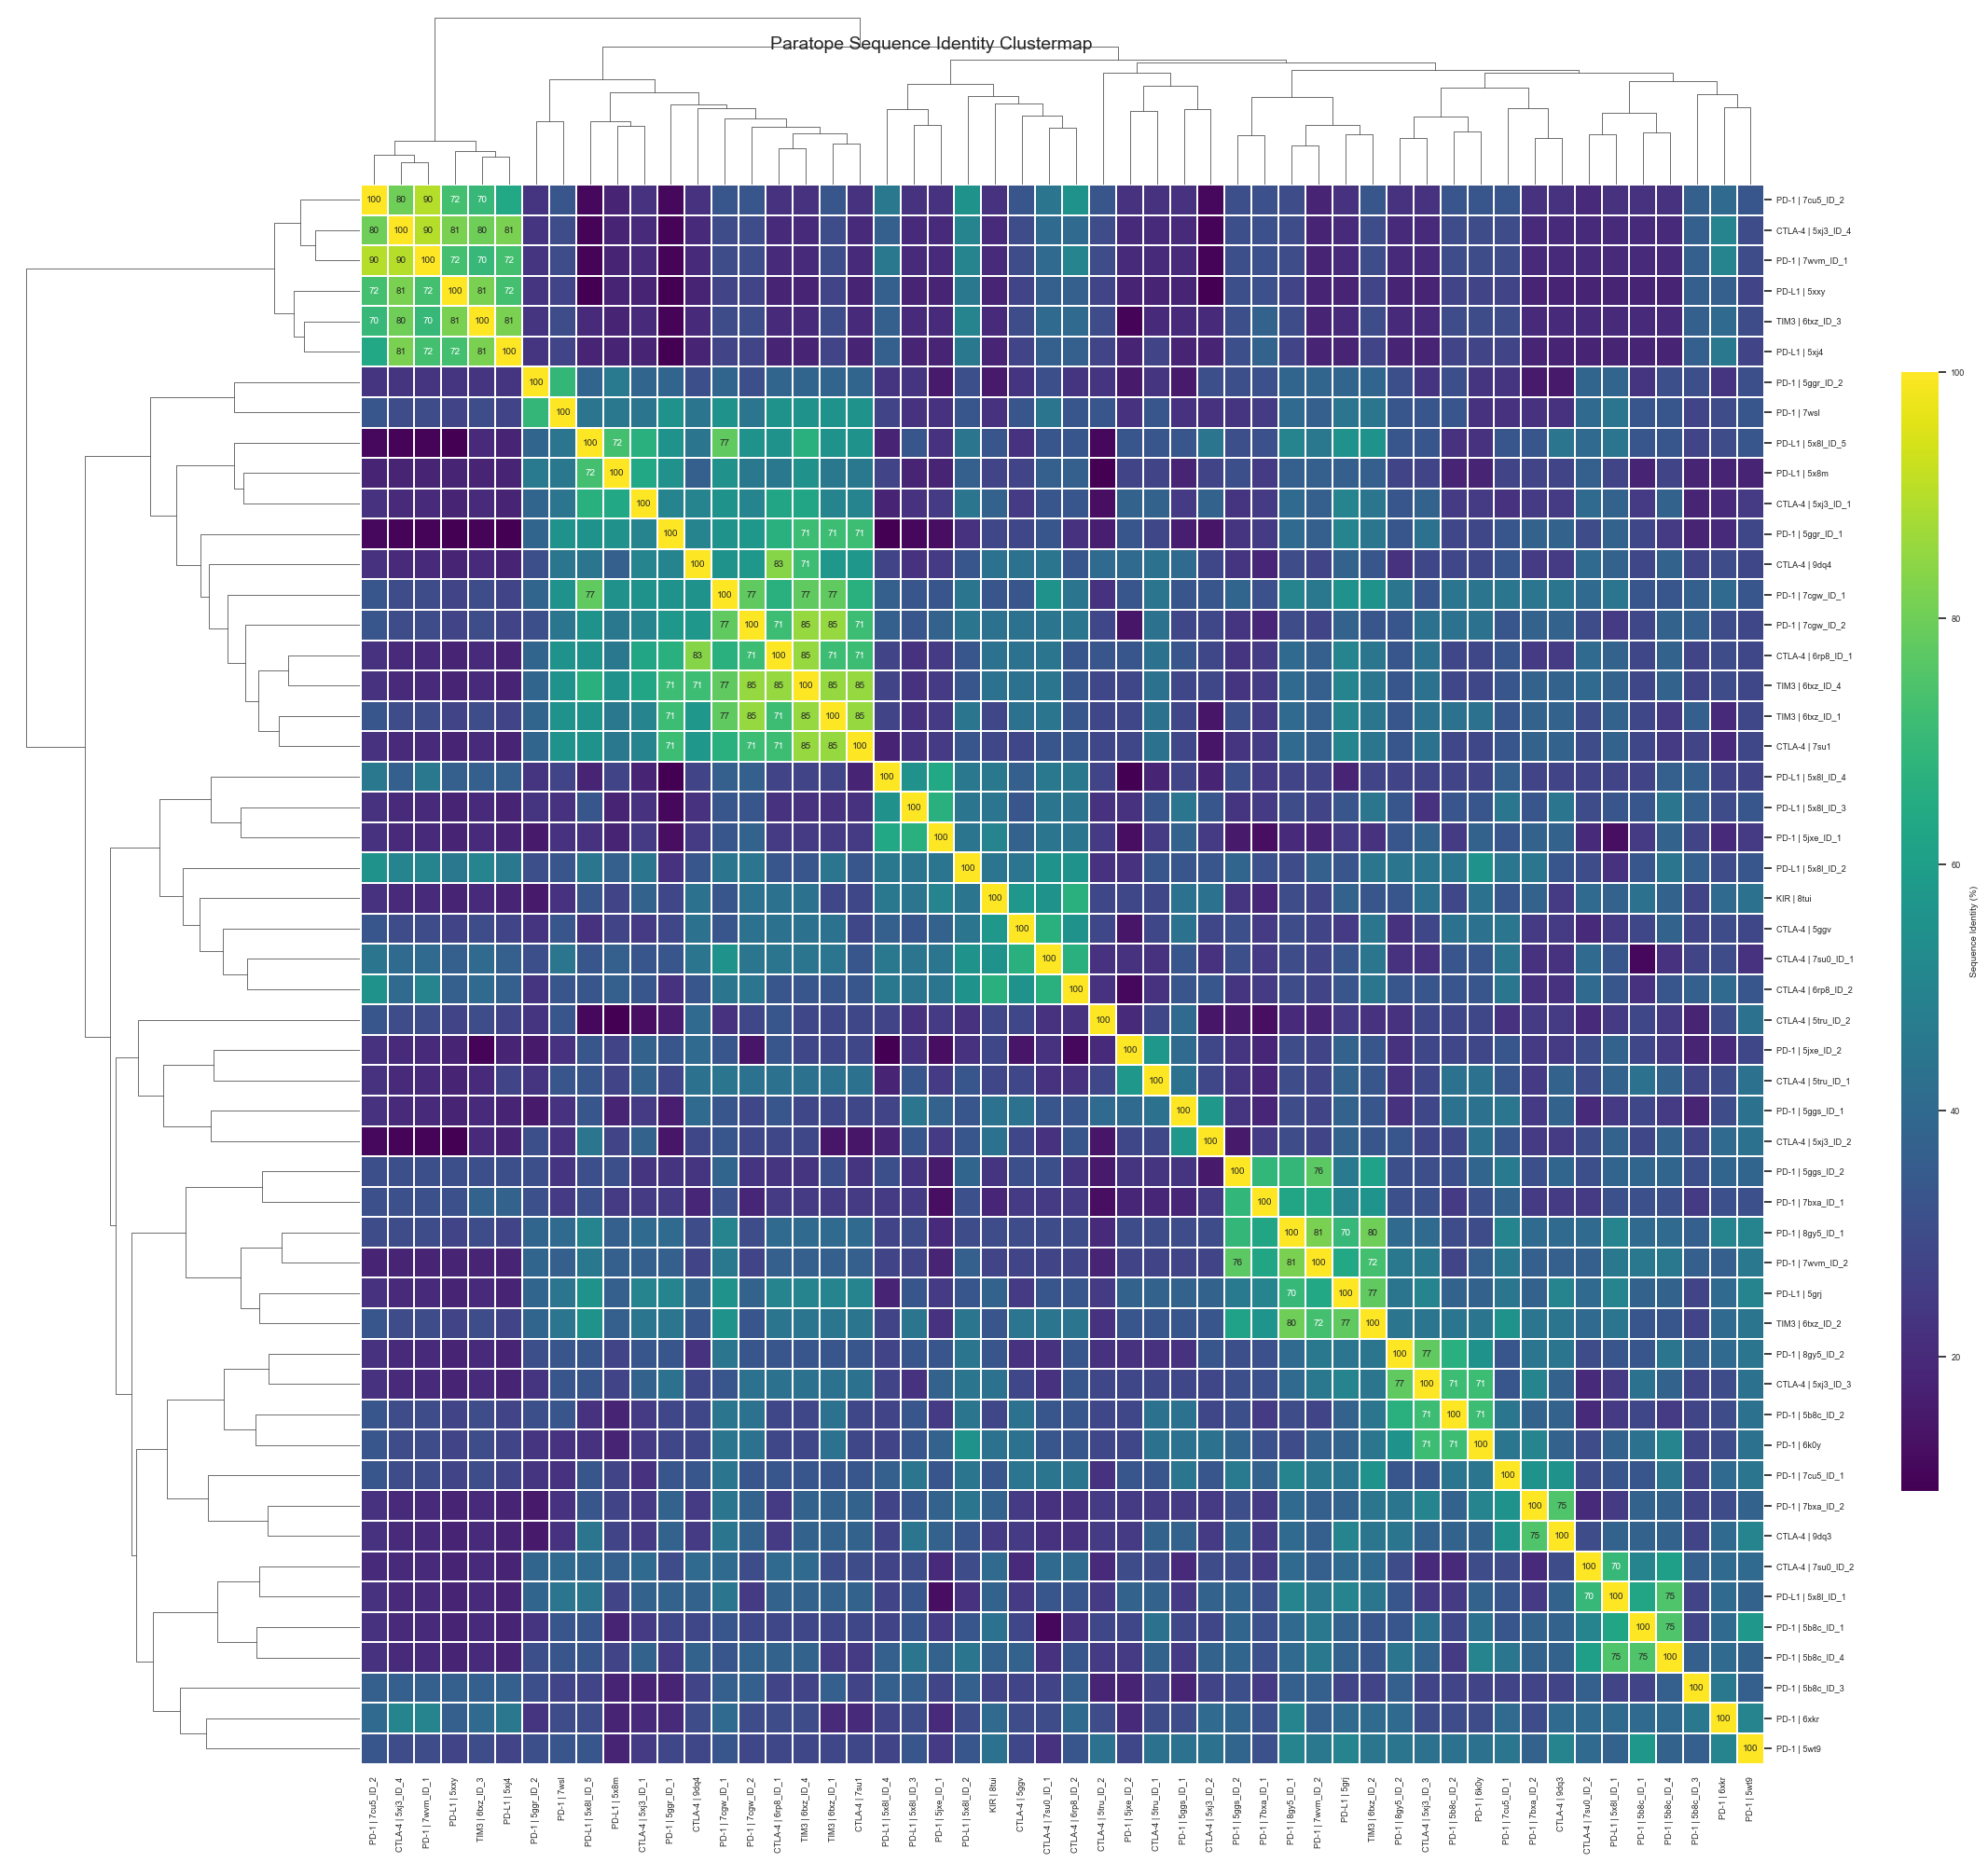

In [74]:
sns.set(font_scale=0.6)

# annotate only high identities
annot_data = df_identity.applymap(lambda x: f"{int(x)}" if x >= 70 else "")

g = sns.clustermap(
    df_identity,
    cmap="viridis",
    figsize=(20, 20),
    annot=annot_data,
    fmt="",
    linewidths=0.3,
    cbar_kws={
        "label": "Sequence Identity (%)",
        "shrink": 1.0,
        "aspect": 10,
        "pad": 0.02
    },
    dendrogram_ratio=(.2, .1),
    xticklabels=True,
    yticklabels=True,
    cbar_pos=(1.02, 0.2, 0.02, 0.6)  
)

g.fig.suptitle(f"{section.capitalize()} Sequence Identity Clustermap", fontsize=14)
plt.savefig(f"plots/structural_analysis/{section.capitalize()}/{section}_clustermap.pdf", dpi=300, bbox_inches="tight")
plt.show()


### Barplot - Sequence Length per PDB ID

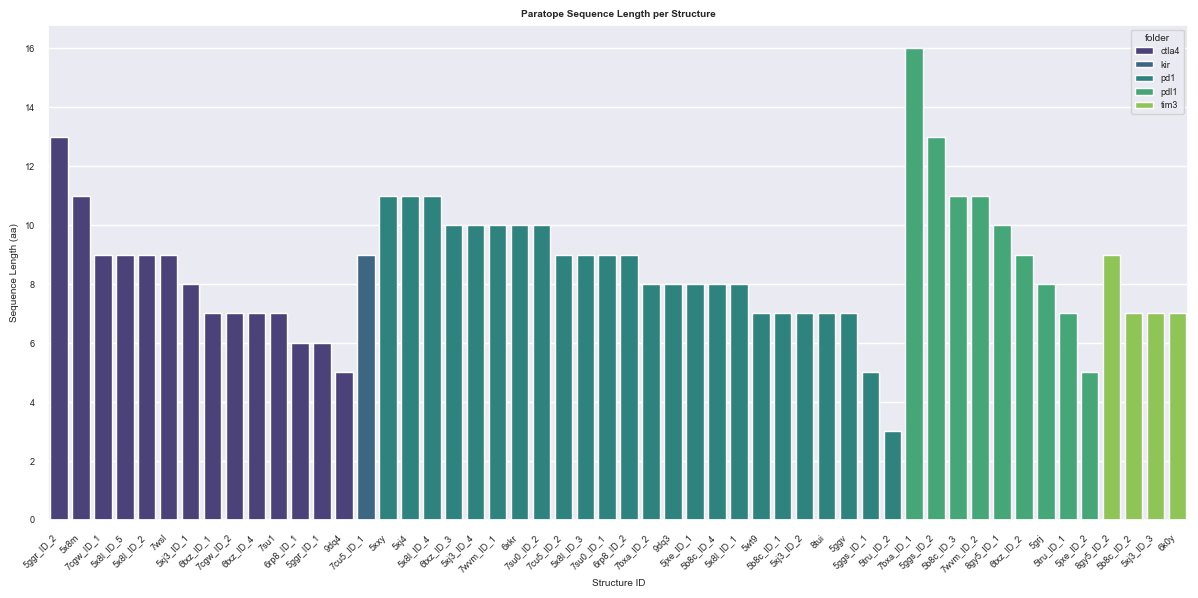

In [75]:
# Add column with sequence length
df_seq[f"{section}_length"] = df_seq[f"{section}_sequence"].str.len()

# # Sort 
df_seq_sorted_by_length = df_seq.sort_values(by=["folder", f"{section}_length"], ascending=[True, False])

# Plot
plt.figure(figsize=(12, 6))
sns.barplot(data=df_seq_sorted_by_length, x="structure_id", y=f"{section}_length", hue="folder", dodge=False, palette="viridis")

plt.title(f"{section.capitalize()} Sequence Length per Structure")
plt.xlabel("Structure ID")
plt.ylabel("Sequence Length (aa)")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.savefig(f"plots/structural_analysis/{section.capitalize()}/{section}_sequence_lengths.pdf", bbox_inches='tight')
plt.show()

In [84]:
# Drop 'pdb_id' aus einem der beiden DataFrames – z. B. aus df_sorted_bs
df_sorted_clean = df_sorted_bs.drop(columns=["pdb_id"])

# Merge – jetzt gibt es keine Konflikte → kein _x, kein _y
df_merged = df_seq.merge(df_sorted_clean, on="structure_id", how="outer")


In [85]:
df_merged

,pdb_id,H_chain,L_chain,antigen_chain,paratope_sequence,folder,structure_id,paratope_length,num_filtered_hbonds,num_salt_bridges,buried_paratope_area,binding_score
0,8gy5,H,L,P,SRDYSTG,pd1,5b8c_ID_1,7,0.126316,0.000000,0.646361,0.179799
1,6txz,H,L,A,YAVKSYY,tim3,5b8c_ID_2,7,0.073684,0.000000,0.389120,0.107298
2,5grj,H,L,A,YYSGYRGTVTT,pdl1,5b8c_ID_3,11,0.078947,0.000000,0.341777,0.099934
3,8gy5,A,B,Q,NSGRDYST,pd1,5b8c_ID_4,8,0.068421,0.666667,0.230070,0.340049
4,7su1,H,L,C,HYGSSW,ctla4,5ggr_ID_1,6,0.089474,0.333333,0.602077,0.289538
5,9dq4,H,L,A,VGKWYRHYGQSWL,ctla4,5ggr_ID_2,13,0.073684,0.000000,0.190680,0.067610
6,7cu5,A,A,Q,SNYQY,pd1,5ggs_ID_1,5,0.052632,0.000000,0.402895,0.101632
7,5x8l,H,M,C,SSDWSYSTYYRWP,pdl1,5ggs_ID_2,13,0.094737,0.000000,0.307142,0.099323
8,7cgw,H,L,P,NDYHNYY,pd1,5ggv,7,0.115789,0.000000,0.684248,0.183165
9,5x8l,S,N,D,WWSYGSYW,pdl1,5grj,8,0.131579,0.000000,0.424162,0.137464


In [86]:
df_merged.to_csv(f"data/structural_analysis/{section.capitalize()}/{section}_hbonds_salt_bridges_summary.csv", index=False)